# Operations Rehearsal for Commissioning April 2024 Data Access Demo

Tutorial notebook for accessing data from the Operations Rehearsal for Commissioning in April 2024 with pointers to other resources, examples, and documentation. Most examples use simulated ComCam data stream.

Last verified to run: 20 Mar 2024

LSST Science Pipelines Version: `w_2024_10`

## What version of the Science Pipelines am I using?

In [1]:
!eups list -s | grep lsst_distrib

lsst_distrib          g4213664e8e+c2911b1728 	current w_2024_16 setup


For a summary of changes between versions, see https://lsst-dm.github.io/lsst_git_changelog/

Import additional python packages that we will need for this tutorial.

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib widget

## How do I find information on data processing campaigns?

See https://confluence.lsstcorp.org/display/DM/Campaigns for the list of productions that the campaign management team has acknowledged as routine and accepted to oversee.

In particular, there is a section for Operations Rehearsal #3 called "DRP on Simulated ComCam data at USDF" for the simulated ComCam data stream.

The repo and collection names are provided, which we will need for the next section.

## How do I instatiate a Butler for data access?

* https://github.com/rubin-dp0/tutorial-notebooks/blob/main/DP02_01_Introduction_to_DP02.ipynb

In [4]:
from lsst.daf.butler import Butler

In [18]:
# One can see all of the collections with the following command
tmp_list = butler.registry.queryCollections()
len(tmp_list)

7959

In [21]:
butler.registry?

Type:        property
String form: <property object at 0x7ff5a8069ee0>
Docstring:  
The object that manages dataset metadata and relationships
(`Registry`).

Many operations that don't involve reading or writing butler datasets
are accessible only via `Registry` methods. Eventually these methods
will be replaced by equivalent `Butler` methods.

In [24]:
# Load operation rehearsal data
# Can use obs_butler.registry.queryCollections to see available collections

repo = '/repo/embargo'
collection = 'LSSTComCamSim/runs/intermittentcumulativeDRP/20240402_03_04/d_2024_03_29/DM-43865'

butler = Butler(repo, collections=collection)
registry = butler.registry

## How do I find the contents of a collection?

In [25]:
# Determine which dataset types exist in the collection
for datasetType in registry.queryDatasetTypes():
    if registry.queryDatasets(datasetType, collections=collection).any(execute=False, exact=False):
        # Limit search results to the data products
        if ('_config' not in datasetType.name) and ('_log' not in datasetType.name) and ('_metadata' not in datasetType.name) and ('_resource_usage' not in datasetType.name):
            print(datasetType)

DatasetType('raw', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure)
DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
DatasetType('camera', {instrument}, Camera, isCalibration=True)
DatasetType('dark', {instrument, detector}, ExposureF, isCalibration=True)
DatasetType('flat', {band, instrument, detector, physical_filter}, ExposureF, isCalibration=True)
DatasetType('gaia_dr2_20200414', {htm7}, SimpleCatalog)
DatasetType('skyMap', {skymap}, SkyMap)
DatasetType('atlas_refcat2_20220201', {htm7}, SimpleCatalog)
DatasetType('packages', {}, Packages)
DatasetType('icSrc_schema', {}, SourceCatalog)
DatasetType('src_schema', {}, SourceCatalog)
DatasetType('icSrc', {band, instrument, day_obs, detector, physical_filter, visit}, SourceCatalog)
DatasetType('icExpBackground', {band, instrument, day_obs, detector, physical_filter, visit}, Background)
DatasetType('icExp', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF)

## Standard Data Model

We will be accessing several tabular data products. A quick reference for the Standard Data Model schema:

https://dm.lsst.org/sdm_schemas/browser/

## How do I get a summary of visits that are included in the collection?

In [26]:
list(butler.registry.queryDatasets('visitTable'))

[DatasetRef(DatasetType('visitTable', {instrument}, DataFrame), {instrument: 'LSSTComCamSim'}, run='LSSTComCamSim/runs/intermittentcumulativeDRP/20240402_03_04/d_2024_03_29/DM-43865/20240417T164702Z', id=defa34ef-afab-4cfd-afc5-47c3227542a6)]

In [27]:
visitTable = butler.get('visitTable')

In [28]:
visitTable

,visit,physical_filter,band,ra,dec,decl,skyRotation,azimuth,altitude,zenithDistance,airmass,expTime,expMidpt,expMidptMJD,obsStart,obsStartMJD
visitId,,,,,,,,,,,,,,,,
7024040200001,7024040200001,r_03,r,125.105053,-15.056578,-15.056578,123.468059,37.462569,71.572021,18.427979,1.055284,30.0,2024-04-02 23:32:17.512001,60402.980758,2024-04-02 23:32:02.512001,60402.980585
7024040200003,7024040200003,r_03,r,125.023361,-14.831762,-14.831762,120.308550,35.976764,71.602774,18.397226,1.054488,30.0,2024-04-02 23:33:40.407993,60402.981718,2024-04-02 23:33:25.407993,60402.981544
7024040200004,7024040200004,r_03,r,125.197284,-15.042250,-15.042250,119.710930,36.329874,71.782081,18.217919,1.053489,30.0,2024-04-02 23:34:22.046494,60402.982200,2024-04-02 23:34:07.046494,60402.982026
7024040200005,7024040200005,r_03,r,124.866513,-14.887771,-14.887771,117.412040,34.733952,71.903143,18.096857,1.052833,30.0,2024-04-02 23:35:03.807508,60402.982683,2024-04-02 23:34:48.807508,60402.982509
7024040200006,7024040200006,r_03,r,124.828815,-14.893919,-14.893919,116.015859,34.178780,72.011046,17.988954,1.052257,30.0,2024-04-02 23:35:45.048998,60402.983160,2024-04-02 23:35:30.048998,60402.982987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7024040400776,7024040400776,r_03,r,300.159351,-41.047094,-41.047094,173.169594,124.770900,67.080617,22.919383,1.101757,30.0,2024-04-05 10:09:04.085509,60405.422964,2024-04-05 10:08:49.085509,60405.422790
7024040400777,7024040400777,r_03,r,300.062454,-40.881522,-40.881522,172.096782,124.549455,67.329007,22.670993,1.099792,30.0,2024-04-05 10:09:45.447993,60405.423443,2024-04-05 10:09:30.447993,60405.423269
7024040400778,7024040400778,r_03,r,299.843691,-40.931590,-40.931590,171.608512,124.940278,67.589417,22.410583,1.097635,30.0,2024-04-05 10:10:26.883500,60405.423922,2024-04-05 10:10:11.883500,60405.423749


## How do I get a quick summary of the science performance of the individual visits?

In [29]:
list(butler.registry.queryDatasets('ccdVisitTable'))

[DatasetRef(DatasetType('ccdVisitTable', {instrument}, DataFrame), {instrument: 'LSSTComCamSim'}, run='LSSTComCamSim/runs/intermittentcumulativeDRP/20240402_03_04/d_2024_03_29/DM-43865/20240417T164702Z', id=9bf0a4c0-381e-4fc1-a5ed-56280958a47c)]

In [30]:
ccdVisitTable = butler.get('ccdVisitTable')

In [31]:
ccdVisitTable

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,...,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec
ccdVisitId,,,,,,,,,,,,,,,,,,,,,
730857472256,7024040200001,r_03,r,124.767763,-15.121609,18.083269,31.242552,2.497141,1698.712769,34.584305,...,4071,3999,124.606906,-15.153879,124.737179,-14.965774,124.928592,-15.089223,124.798403,-15.277451
730857472257,7024040200001,r_03,r,124.902773,-14.926327,18.317957,31.222132,2.510689,1669.825317,32.799969,...,4071,3999,124.742070,-14.958705,124.872118,-14.770513,125.063439,-14.893841,124.933479,-15.082149
730857472258,7024040200001,r_03,r,125.037544,-14.730973,18.552645,31.244072,2.522848,1704.507935,33.605240,...,4071,3999,124.877001,-14.763441,125.006814,-14.575185,125.198044,-14.698400,125.068318,-14.886765
730857472259,7024040200001,r_03,r,124.970127,-15.251984,18.076450,31.250017,2.507668,1711.987061,34.254421,...,4071,3999,124.809182,-15.284396,124.939366,-15.096164,125.131030,-15.219455,125.000930,-15.407785
730857472260,7024040200001,r_03,r,125.105039,-15.056579,18.311228,31.247614,2.507546,1709.427124,33.508781,...,4071,3999,124.944253,-15.089090,125.074208,-14.900774,125.265777,-15.023955,125.135914,-15.212377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730874448898,7024040400780,r_03,r,300.443863,-40.770817,22.374783,31.271347,1.445220,1210.585449,28.795427,...,4071,3999,300.270406,-40.681996,300.563805,-40.640850,300.617779,-40.859384,300.323432,-40.900676
730874448899,7024040400780,r_03,r,299.887851,-41.085968,22.095676,31.277943,1.448377,1212.444824,29.429699,...,4071,3999,299.714335,-40.996305,300.009480,-40.956554,300.061851,-41.175372,299.765755,-41.215244
730874448900,7024040400780,r_03,r,300.194401,-41.044251,22.295435,31.273817,1.450633,1212.448975,28.529161,...,4071,3999,300.020564,-40.955046,300.315355,-40.914515,300.368715,-41.133193,300.072970,-41.173859


In [32]:
ccdVisitTable.columns

Index(['visitId', 'physical_filter', 'band', 'ra', 'dec', 'zenithDistance',
       'zeroPoint', 'psfSigma', 'skyBg', 'skyNoise', 'astromOffsetMean',
       'astromOffsetStd', 'nPsfStar', 'psfStarDeltaE1Median',
       'psfStarDeltaE2Median', 'psfStarDeltaE1Scatter',
       'psfStarDeltaE2Scatter', 'psfStarDeltaSizeMedian',
       'psfStarDeltaSizeScatter', 'psfStarScaledDeltaSizeScatter',
       'psfTraceRadiusDelta', 'maxDistToNearestPsf', 'effTime',
       'effTimePsfSigmaScale', 'effTimeSkyBgScale', 'effTimeZeroPointScale',
       'decl', 'detector', 'seeing', 'skyRotation', 'expMidpt', 'expMidptMJD',
       'expTime', 'obsStart', 'obsStartMJD', 'darkTime', 'xSize', 'ySize',
       'llcra', 'llcdec', 'ulcra', 'ulcdec', 'urcra', 'urcdec', 'lrcra',
       'lrcdec'],
      dtype='object')

In [33]:
#in_band = np.where(ccdVisitTable['band'] == 'g')[0]
in_band = ccdVisitTable['band'] == 'g'
ccdVisitTable['band'][in_band]

ccdVisitId
730857569536    g
730857569537    g
730857569538    g
730857569539    g
730857569540    g
               ..
730874443780    g
730874443781    g
730874443782    g
730874443783    g
730874443784    g
Name: band, Length: 3929, dtype: object

Text(0, 0.5, 'zeroPoint')

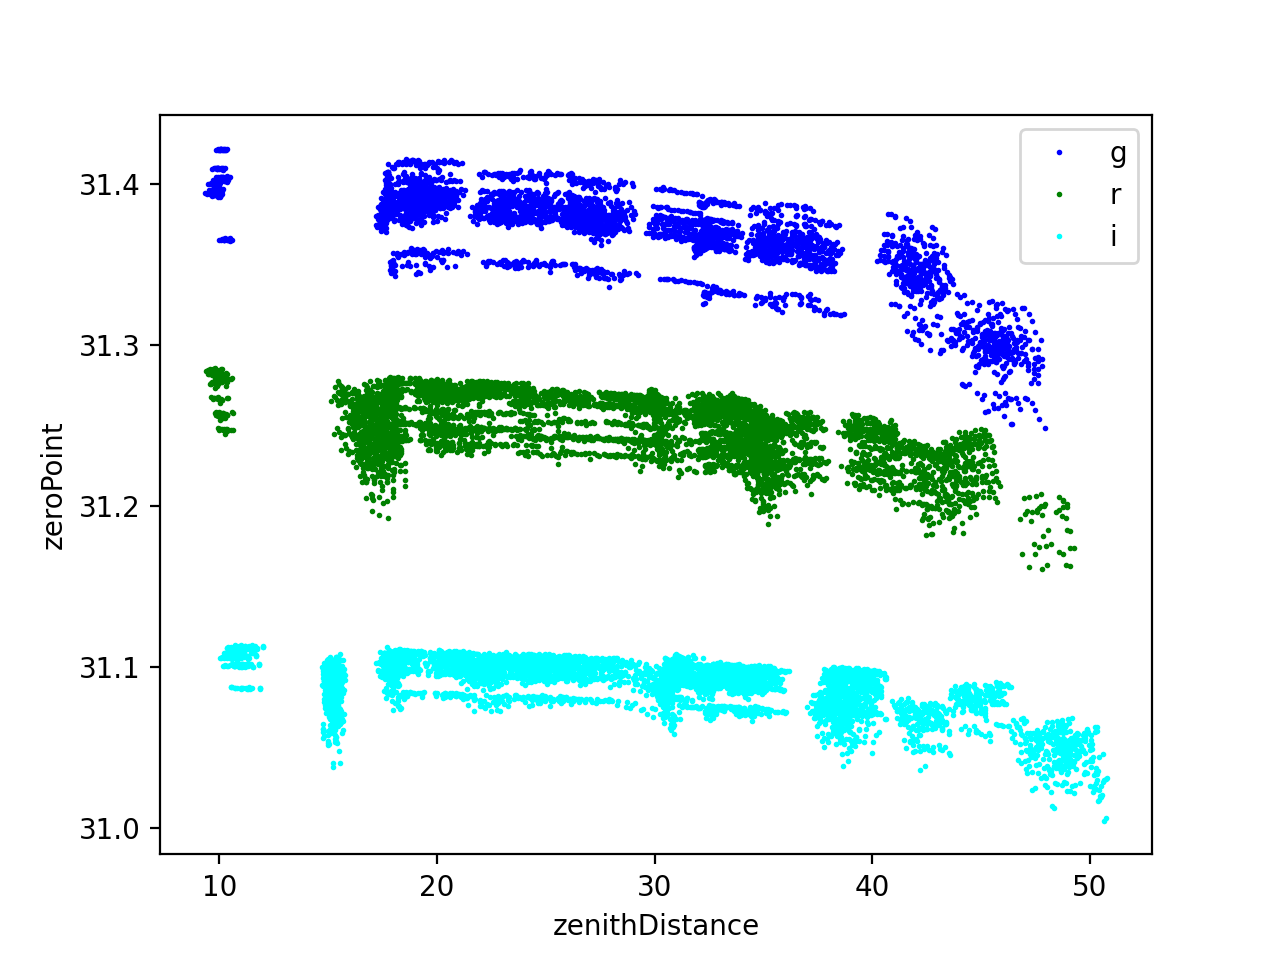

In [34]:
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
       'i': 'cyan', 'z': 'orange', 'y': 'red'}

plt.figure(dpi=200)
for bandname in f2c:
    in_band = ccdVisitTable['band'] == bandname
    if np.sum(in_band) > 0:
        plt.plot(ccdVisitTable['zenithDistance'][in_band], ccdVisitTable['zeroPoint'][in_band], 
                 'o', markersize=1, color=f2c[bandname], label=bandname)
plt.legend()
plt.xlabel('zenithDistance')
plt.ylabel('zeroPoint')

Example analyses to try
* https://rubinobs.atlassian.net/jira/software/c/projects/DM/boards/174?selectedIssue=DM-43070

## How do I figure out which tracts have data?

In [35]:
for dtype in sorted(registry.queryDatasetTypes(expression="*nImage*")):
    print(dtype.name)

deepCoadd_nImage
goodSeeingCoadd_nImage


In [36]:
nImage_refs = list(butler.registry.queryDatasets('deepCoadd_nImage'))

In [37]:
tracts = np.unique([ref.dataId['tract'] for ref in nImage_refs])
print(tracts)

bands = np.unique([ref.dataId['band'] for ref in nImage_refs])
print(bands)

[2494 2495 2661 2662 3200 3345 3346 3384 3385 3533 3534 6914 6915 7149
 7445 7446 7683 7684 9347 9348 9570 9590 9591 9637 9638 9812 9813 9880
 9881]
['g' 'i' 'r']


In [38]:
# Check which tracts actually have a lot of visit coverage:
for tract in tracts:
    visits = list(butler.registry.queryDatasets('visitSummary', tract=tract, skymap='ops_rehersal_prep_2k_v1', findFirst=True))
    print(tract, len(visits))

2494 1140
2495 1526
2661 310
2662 712
3200 42
3345 703
3346 1526
3384 710
3385 146
3533 901
3534 188
6914 1789
6915 993
7149 1107
7445 2143
7446 839
7683 147
7684 72
9347 1595
9348 731
9570 31
9590 1595
9591 727
9637 31
9638 529
9812 222
9813 2313
9880 2076
9881 43


In [39]:
skymap = butler.get('skyMap', skymap='ops_rehersal_prep_2k_v1')
tract = skymap.generateTract(3346)
sp2 = tract.getCtrCoord()
sp2

SpherePoint(225.7297297297297*degrees, -40.90909090909091*degrees)

## How do I access a source table?

In [40]:
sourceTable_refs = sorted(butler.registry.queryDatasets('sourceTable_visit'))
sourceTable = butler.get(sourceTable_refs[0])
sourceTable

,coord_ra,coord_dec,ccdVisitId,parentSourceId,x,y,xErr,yErr,ra,dec,...,hsmShapeRegauss_flag_galsim,hsmShapeRegauss_flag_no_pixels,hsmShapeRegauss_flag_not_contained,hsmShapeRegauss_flag_parent_source,sky_source,detect_isPrimary,visit,detector,band,physical_filter
sourceId,,,,,,,,,,,,,,,,,,,,,
3065438419313229825,124.612835,-15.146175,730857472256,0,172.000000,8.000000,NaN,NaN,124.612835,-15.146175,...,False,False,False,False,False,True,7024040200001,0,r,r_03
3065438419313229826,124.644203,-15.101112,730857472256,0,1149.000000,10.000000,NaN,NaN,124.644203,-15.101112,...,False,False,False,False,False,True,7024040200001,0,r,r_03
3065438419313229827,124.672626,-15.059830,730857472256,0,2041.011964,7.479162,0.341569,0.434945,124.672626,-15.059830,...,False,False,False,False,False,True,7024040200001,0,r,r_03
3065438419313229828,124.678793,-15.050977,730857472256,0,2233.000000,8.000000,NaN,NaN,124.678793,-15.050977,...,False,False,False,False,False,True,7024040200001,0,r,r_03
3065438419313229829,124.685382,-15.041461,730857472256,0,2439.000000,8.000000,NaN,NaN,124.685382,-15.041461,...,False,False,False,False,False,True,7024040200001,0,r,r_03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3065438419346787078,125.520408,-15.076022,730857472264,3065438419346786294,1513.797967,3978.731271,0.037999,0.047931,125.520408,-15.076022,...,False,False,False,False,False,True,7024040200001,8,r,r_03
3065438419346787079,125.519898,-15.075339,730857472264,3065438419346786294,1519.147770,3964.545668,0.151362,0.135653,125.519898,-15.075339,...,False,False,False,False,False,True,7024040200001,8,r,r_03
3065438419346787080,125.520014,-15.076824,730857472264,3065438419346786294,1498.000000,3981.000000,NaN,NaN,125.520014,-15.076824,...,False,False,False,False,False,True,7024040200001,8,r,r_03


In [41]:
sourceTable.columns.values

array(['coord_ra', 'coord_dec', 'ccdVisitId', 'parentSourceId', 'x', 'y',
       'xErr', 'yErr', 'ra', 'dec', 'decl', 'raErr', 'decErr',
       'ra_dec_Cov', 'calibFlux', 'calibFluxErr', 'ap03Flux',
       'ap03FluxErr', 'ap03Flux_flag', 'ap06Flux', 'ap06FluxErr',
       'ap06Flux_flag', 'ap09Flux', 'ap09FluxErr', 'ap09Flux_flag',
       'ap12Flux', 'ap12FluxErr', 'ap12Flux_flag', 'ap17Flux',
       'ap17FluxErr', 'ap17Flux_flag', 'ap25Flux', 'ap25FluxErr',
       'ap25Flux_flag', 'ap35Flux', 'ap35FluxErr', 'ap35Flux_flag',
       'ap50Flux', 'ap50FluxErr', 'ap50Flux_flag', 'ap70Flux',
       'ap70FluxErr', 'ap70Flux_flag', 'sky', 'skyErr', 'psfFlux',
       'psfFluxErr', 'ixx', 'iyy', 'ixy', 'ixxPSF', 'iyyPSF', 'ixyPSF',
       'ixxDebiasedPSF', 'iyyDebiasedPSF', 'ixyDebiasedPSF',
       'gaussianFlux', 'gaussianFluxErr', 'extendedness',
       'sizeExtendedness', 'localPhotoCalib', 'localPhotoCalib_flag',
       'localPhotoCalibErr', 'localWcs_flag', 'localWcs_CDMatrix_2_1',
       '

## How do I access an object table?

In [42]:
objectTable_refs = sorted(butler.registry.queryDatasets('objectTable_tract'))
objectTable = butler.get(objectTable_refs[0])
objectTable

column,deblend_nChild,deblend_failed,coord_ra,deblend_nPeaks,deblend_logL,refFwhm,shape_xy,deblend_incompleteData,deblend_isolatedParent,detect_isDeblendedModelSource,...,y_kronFlux_flag,y_kronFlux_flag_bad_radius,y_kronFlux_flag_bad_shape,y_kronFlux_flag_bad_shape_no_psf,y_kronFlux_flag_edge,y_kronFlux_flag_no_fallback_radius,y_kronFlux_flag_no_minimum_radius,y_kronFlux_flag_small_radius,y_kronFlux_flag_used_minimum_radius,y_kronFlux_flag_used_psf_radius
objectId,,,,,,,,,,,,,,,,,,,,,
845556327596949505,2,False,279.740818,2,-288.219543,0.565513,-0.015549,False,False,False,...,True,True,True,True,True,True,True,True,True,True
845556327596949506,2,False,279.727141,2,-448.469727,0.559760,-0.070411,False,False,False,...,True,True,True,True,True,True,True,True,True,True
845556327596949507,1,False,279.723278,1,-88.965057,0.563860,0.549419,False,False,False,...,True,True,True,True,True,True,True,True,True,True
845556327596949508,1,False,279.710177,1,-212.806824,0.567614,0.022534,False,False,False,...,True,True,True,True,True,True,True,True,True,True
845556327596949509,4,False,279.702723,4,-4051.718506,0.569331,0.355640,False,False,False,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845594810503923735,0,False,279.535466,1,NaN,0.481691,0.003104,False,False,True,...,True,True,True,True,True,True,True,True,True,True
845594810503923736,0,False,279.534122,1,NaN,0.482820,-0.990164,False,False,True,...,True,True,True,True,True,True,True,True,True,True
845594810503923737,0,False,279.535680,1,NaN,0.481203,-0.154573,False,False,True,...,True,True,True,True,True,True,True,True,True,True


In [43]:
#for column in objectTable.columns.values:
#    print(column)

## How do I visualize a pixel-level image?

Suggested references:
* https://github.com/rubin-dp0/tutorial-notebooks/blob/main/DP02_03a_Image_Display_and_Manipulation.ipynb
* https://github.com/rubin-dp0/tutorial-notebooks/blob/main/DP02_03b_Image_Display_with_Firefly.ipynb
* https://github.com/yalsayyad/dm_notebooks/blob/master/examples/Firefly.ipynb

In [44]:
# Find a calexp

In [45]:
calexp_refs_g = sorted(registry.queryDatasets('calexp', band = 'g'))

In [46]:
coadd_refs_g = sorted(registry.queryDatasets('deepCoadd', band = 'g'))

In [47]:
coadd_refs_r = sorted(registry.queryDatasets('deepCoadd', band = 'r'))

In [48]:
coadd_refs_i = sorted(registry.queryDatasets('deepCoadd', band = 'i'))

In [49]:
calexp_refs_r = sorted(registry.queryDatasets('calexp', band = 'r'))

In [50]:
calexp_refs_i = sorted(registry.queryDatasets('calexp', band = 'i'))

In [51]:
len(calexp_refs_g), len(calexp_refs_r), len(calexp_refs_i)

(6572, 6954, 6706)

In [52]:
calexp_refs_g[0]

DatasetRef(DatasetType('calexp', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF), {instrument: 'LSSTComCamSim', detector: 0, visit: 7024040200021, band: 'g', day_obs: 20240402, physical_filter: 'g_01'}, run='LSSTComCamSim/quickLook/24', id=2faa8c1d-cf1a-4027-bfdf-5ab1e664b287)

In [53]:
calexp_refs_r[0]

DatasetRef(DatasetType('calexp', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF), {instrument: 'LSSTComCamSim', detector: 0, visit: 7024032500002, band: 'r', day_obs: 20240325, physical_filter: 'r_03'}, run='LSSTComCamSim/quickLook/24', id=7e35a124-6bf2-469e-82f7-7db35435d358)

In [54]:
calexp_refs_i[0]

DatasetRef(DatasetType('calexp', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF), {instrument: 'LSSTComCamSim', detector: 0, visit: 7024032900060, band: 'i', day_obs: 20240329, physical_filter: 'i_06'}, run='LSSTComCamSim/quickLook/24', id=d5f0f2cd-3ba1-4f97-9083-a1deb2bb276d)

In [55]:
calexp = butler.get(calexp_refs_g[0])

In [56]:
coadd = butler.get(coadd_refs_g[0])

In [57]:
import lsst.afw.display as afwDisplay

In [58]:
afwDisplay.setDefaultBackend('matplotlib')

Inline image visualization

(-0.5, 4071.5, -0.5, 3999.5)

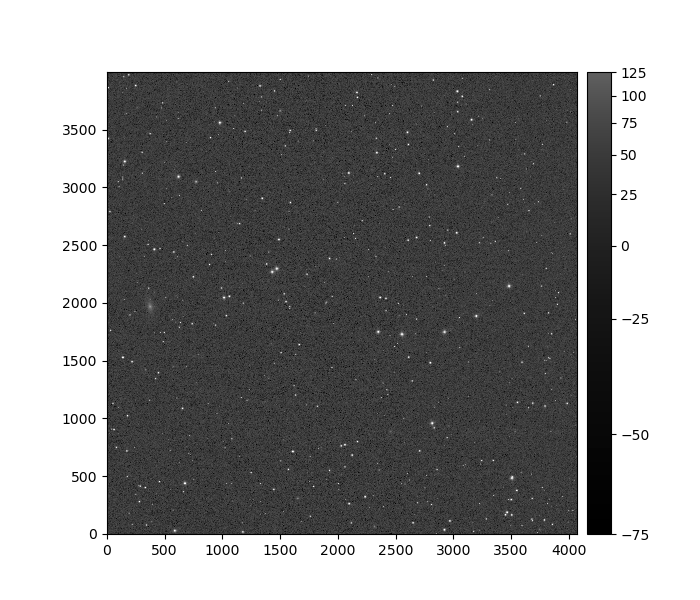

In [59]:
fig = plt.figure(figsize=(7, 6))
afw_display = afwDisplay.Display(fig)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp.image)
plt.gca().axis('on')

(-200.5, 1849.5, 8049.5, 10099.5)

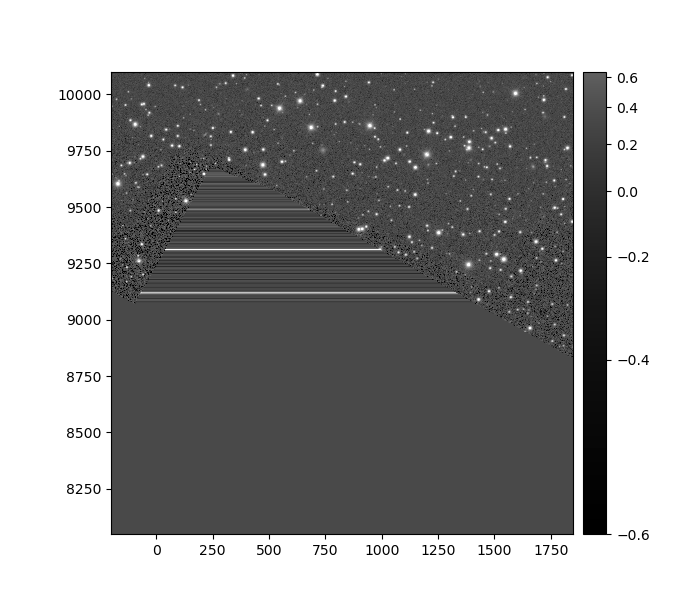

In [60]:
fig = plt.figure(figsize=(7, 6))
afw_display = afwDisplay.Display(fig)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(coadd.image)
plt.gca().axis('on')

(-200.5, 1849.5, 8049.5, 10099.5)

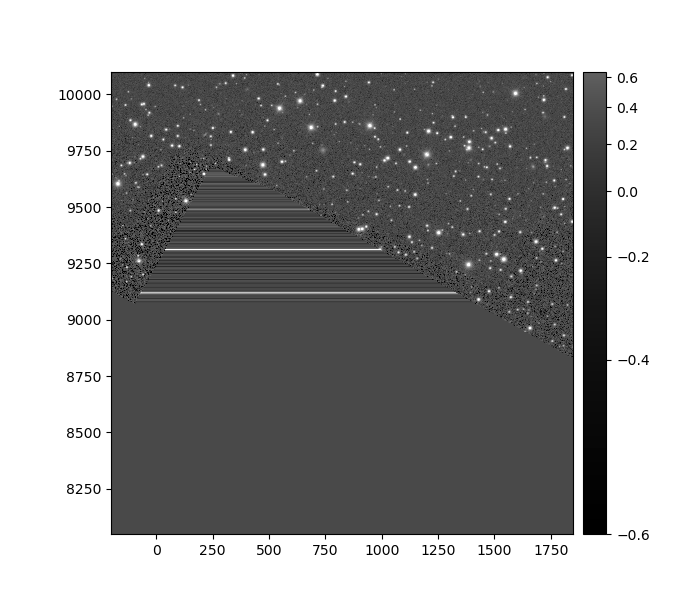

In [61]:
fig = plt.figure(figsize=(7, 6))
afw_display = afwDisplay.Display(fig)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(coadd.image)
plt.gca().axis('on')

Interactive data visualization w/ Firefly. This will open a new tab.

In [62]:
afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.Display(frame=1)

In [63]:
afw_display.mtv(calexp)

## How do I access science performance metrics computed as part of the pipeline (Analysis Tools)?

Additional suggested resources:
* https://github.com/lsst-dm/analysis_tools_examples/blob/main/atoolsInvestigation.ipynb
* https://github.com/lsst-dm/analysis_tools_examples/blob/main/reconstructorDemo.ipynb
* https://github.com/lsst-dm/analysis_tools_examples/blob/main/data_access_demo.ipynb

In [88]:
from lsst.analysis.tools.tasks.reconstructor import reconstructAnalysisTools

In [96]:
dataId = {"tract": 3346, "skymap": "ops_rehersal_prep_2k_v1"}
#dataId = {"tract": 3346, "skymap": "DC2"}

In [97]:
refs = sorted(butler.registry.queryDatasets("objectTableCore_metrics", collections=collection, dataId=dataId))

In [98]:
refs

[DatasetRef(DatasetType('objectTableCore_metrics', {skymap, tract}, MetricMeasurementBundle), {skymap: 'ops_rehersal_prep_2k_v1', tract: 3346}, run='LSSTComCamSim/runs/intermittentcumulativeDRP/20240402_03_04/d_2024_03_29/DM-43865/20240413T021427Z', id=422619f2-1016-4f75-839b-22d10e41fb74)]

In [99]:
objectTable_metrics = butler.get("objectTableCore_metrics", dataId=dataId, collections=collection)

In [100]:
for dtype in sorted(registry.queryDatasetTypes(expression="*analyzeObjectTableCore*")):
    print(dtype.name)

analyzeObjectTableCore_config
analyzeObjectTableCore_log
analyzeObjectTableCore_metadata


In [101]:
# Access the configuration
objectTable_config = butler.get("analyzeObjectTableCore_config", dataId=dataId, collections=collection)
# objectTable_config.toDict()

ValueError: Failure from formatter 'lsst.pipe.base.formatters.pexConfig.PexConfigFormatter' for dataset 74bcc739-1ef3-4695-8c88-833f25095411 (analyzeObjectTableCore_config from s3://rubin-summit-users/LSSTComCamSim/runs/intermittentcumulativeDRP/20240402_03_04/d_2024_03_29/DM-43865/20240413T021427Z/analyzeObjectTableCore_config/analyzeObjectTableCore_config_LSSTComCamSim_runs_intermittentcumulativeDRP_20240402_03_04_d_2024_03_29_DM-43865_20240413T021427Z.py): lsst.analysis.tools.interfaces._stages.BasePrep has no attribute keysToLoad

In [ ]:
# objectTable_metrics.data

In [44]:
taskState, inputData = reconstructAnalysisTools(butler, 
                                                collection=collection,
                                                label="analyzeObjectTableCore",
                                                dataId=dataId, 
                                                callback=None
)

ValueError: Failure from formatter 'lsst.pipe.base.formatters.pexConfig.PexConfigFormatter' for dataset 12b88aeb-aadc-4482-b01d-27b5435d23f9 (analyzeObjectTableCore_config from file:///sdf/group/rubin/repo/ops-rehearsal-3-prep/u/homer/htc-test1/20240223T180745Z/analyzeObjectTableCore_config/analyzeObjectTableCore_config_u_homer_htc-test1_20240223T180745Z.py): lsst.analysis.tools.interfaces._stages.BasePrep has no attribute keysToLoad

In [102]:
inputData['data']

NameError: name 'inputData' is not defined

In [103]:
for action in taskState.atools:
    print(action.identity)

NameError: name 'taskState' is not defined

In [104]:
plotInfoDict = {"run": collection, "bands": "i", "tract": 7445, "tableName": "objectTable_tract"}
fig = taskState.atools.shapeSizeFractionalDiff(inputData["data"], plotInfo=plotInfoDict, skymap=inputData['skymap'], band="i")

NameError: name 'taskState' is not defined

The brighter-fatter correction was not turned on in "Pass 1" iteration of the data reduction.

## How do I query science performance metrics and system telemetry (Sasquatch and EFD)?

https://sasquatch.lsst.io/user-guide/analysistools.html

https://github.com/lsst-dm/analysis_tools_examples/blob/main/sasquatch_analysis_tools_demo.ipynb

In [105]:
from lsst_efd_client import EfdClient
client = EfdClient("usdfdev_efd", db_name="lsst.dm")

In [106]:
topics = await client.get_topics()
for t in topics: print(t)

lsst.dm.NumDiaSources
lsst.dm.NumStreakCenterDiaSources
lsst.dm.NumStreakDiaSources
lsst.dm.ap12PsfSky
lsst.dm.astromColorDiffMetrics
lsst.dm.astromDiffMetrics
lsst.dm.blendMetrics
lsst.dm.calexpMetrics
lsst.dm.calexpSummaryMetrics
lsst.dm.calibrate
lsst.dm.constantTool
lsst.dm.diaSourcesGoodVsBadRatio
lsst.dm.diffimMetadataMetric
lsst.dm.e1Diff
lsst.dm.e1DiffScatterMetric
lsst.dm.e2Diff
lsst.dm.e2DiffScatterMetric
lsst.dm.isolatedDeblenderMetrics
lsst.dm.matchedRefCModelColorChi
lsst.dm.matchedRefCModelColorDiff
lsst.dm.matchedRefCModelFluxChiMetric
lsst.dm.matchedRefCModelMagChi
lsst.dm.matchedRefCModelMagDiff
lsst.dm.matchedRefCModelMagDiffMetric
lsst.dm.matchedRefMagChiMetric
lsst.dm.matchedRefPositionXChi
lsst.dm.matchedRefPositionXChiMetric
lsst.dm.matchedRefPositionXDiff
lsst.dm.matchedRefPositionXDiffMetric
lsst.dm.matchedRefPositionYChi
lsst.dm.matchedRefPositionYChiMetric
lsst.dm.matchedRefPositionYDiff
lsst.dm.matchedRefPositionYDiffMetric
lsst.dm.numDiaSourcesAll
lsst.dm.nu

In [107]:
query = '''SELECT * FROM "lsst.dm.e1Diff" WHERE time > now() - 100d '''
#query = '''SELECT * FROM "lsst.dm.calexpMetrics" WHERE time > now() - 100d '''
df = await client.influx_client.query(query)
df.columns.values

array(['band', 'dataset_tag', 'dataset_tag_1', 'dataset_type', 'day_obs',
       'detector', 'exposure', 'g_highSNStars_count',
       'g_highSNStars_median', 'g_highSNStars_sigmaMad',
       'g_lowSNStars_count', 'g_lowSNStars_median',
       'g_lowSNStars_sigmaMad', 'group', 'i_highSNStars_count',
       'i_highSNStars_median', 'i_highSNStars_sigmaMad',
       'i_lowSNStars_count', 'i_lowSNStars_median',
       'i_lowSNStars_sigmaMad', 'id', 'instrument', 'patch',
       'physical_filter', 'r_highSNStars_count', 'r_highSNStars_median',
       'r_highSNStars_sigmaMad', 'r_lowSNStars_count',
       'r_lowSNStars_median', 'r_lowSNStars_sigmaMad',
       'reference_package', 'reference_package_timestamp',
       'reference_package_version', 'run', 'run_1', 'run_timestamp',
       'skymap', 'skymap_1', 'timestamp', 'tract', 'tract_1',
       'u_highSNStars_count', 'u_highSNStars_median',
       'u_highSNStars_sigmaMad', 'u_lowSNStars_count',
       'u_lowSNStars_median', 'u_lowSNStars_sig

In [108]:
np.unique(df['dataset_tag'])

array(['DC2/TestMed1', 'Generic', 'HSC/RC2', 'HSC/RC2_subset/nightly',
       'LATISS/DRP', 'intermittentcumulativeDRP', 'nightlyvalidation'],
      dtype=object)

## How do I access science performance plots generated as part of the pipeline (Plot Navigator)?

https://usdf-rsp.slac.stanford.edu/plot-navigator/dashboard_gen3

Try a repo and collection for Operations Rehearsal 3

## How do I create new science performance plots and metrics to be computed as part of the pipeline (Analysis Tools)? 

Suggested resources with examples:

* https://pipelines.lsst.io/v/daily/modules/lsst.analysis.tools/getting-started.html#analysis-tools-getting-started
* https://github.com/lsst-dm/analysis_tools_examples/blob/main/atoolsInvestigation.ipynb
* https://github.com/lsst-dm/analysis_tools_examples/blob/main/data_access_demo.ipynb

## How do I access and visualize survey property maps?

https://github.com/rubin-dp0/tutorial-notebooks/blob/main/DP02_03c_Survey_Property_Maps.ipynb

https://github.com/LSSTDESC/skyproj/tree/main/tutorial

In [109]:
import skyproj

In [110]:
for dtype in sorted(registry.queryDatasetTypes(expression="*consolidated_map*")):
    print(dtype.name)

deepCoadd_dcr_ddec_consolidated_map_weighted_mean
deepCoadd_dcr_dra_consolidated_map_weighted_mean
deepCoadd_dcr_e1_consolidated_map_weighted_mean
deepCoadd_dcr_e2_consolidated_map_weighted_mean
deepCoadd_epoch_consolidated_map_max
deepCoadd_epoch_consolidated_map_mean
deepCoadd_epoch_consolidated_map_min
deepCoadd_exposure_time_consolidated_map_sum
deepCoadd_psf_e1_consolidated_map_weighted_mean
deepCoadd_psf_e2_consolidated_map_weighted_mean
deepCoadd_psf_maglim_consolidated_map_weighted_mean
deepCoadd_psf_size_consolidated_map_weighted_mean
deepCoadd_sky_background_consolidated_map_weighted_mean
deepCoadd_sky_noise_consolidated_map_weighted_mean


In [111]:
sorted(registry.queryDatasets('deepCoadd_psf_maglim_consolidated_map_weighted_mean'))

[DatasetRef(DatasetType('deepCoadd_psf_maglim_consolidated_map_weighted_mean', {band, skymap}, HealSparseMap), {band: 'g', skymap: 'ops_rehersal_prep_2k_v1'}, run='LSSTComCamSim/runs/intermittentcumulativeDRP/20240402_03_04/d_2024_03_29/DM-43865/20240416T212834Z', id=98ee63d5-4920-44d1-98d2-8e93ff329bf0),
 DatasetRef(DatasetType('deepCoadd_psf_maglim_consolidated_map_weighted_mean', {band, skymap}, HealSparseMap), {band: 'i', skymap: 'ops_rehersal_prep_2k_v1'}, run='LSSTComCamSim/runs/intermittentcumulativeDRP/20240402_03_04/d_2024_03_29/DM-43865/20240416T212834Z', id=d2d6b8aa-2850-4064-a64d-218f3361112a),
 DatasetRef(DatasetType('deepCoadd_psf_maglim_consolidated_map_weighted_mean', {band, skymap}, HealSparseMap), {band: 'r', skymap: 'ops_rehersal_prep_2k_v1'}, run='LSSTComCamSim/runs/intermittentcumulativeDRP/20240402_03_04/d_2024_03_29/DM-43865/20240416T212834Z', id=c0eaf319-0f10-4d14-a2b1-5e229313fcdd)]

In [115]:
hspmap = butler.get('deepCoadd_psf_maglim_consolidated_map_weighted_mean', band='i', skymap='ops_rehersal_prep_2k_v1')

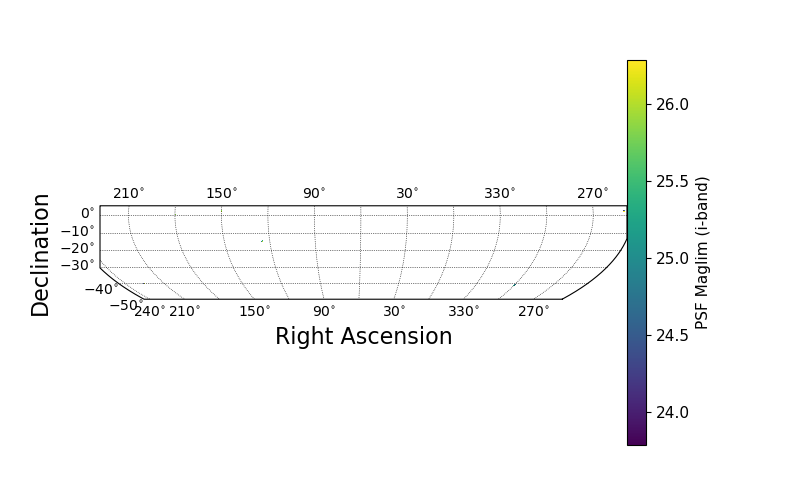

In [116]:
fig, ax = plt.subplots(figsize=(8, 5))
sp = skyproj.McBrydeSkyproj(ax=ax, lon_0=65.0)
sp.draw_hspmap(hspmap)
sp.draw_colorbar(label='PSF Maglim (i-band)')
plt.show()

del fig, ax, sp

The fields are small when viewed at this scale. Try zooming in, for example, on the COSMOS field at (RA, Dec) = (150, 2).